# Real Time Network State Analysis using Machine Learning Tools

Charlie Meyers

## Back Ground Information

### Signal Processing

To even begin how to model a signal at a given point of space and time, we have to start with the model of the signal itself. All signals can be modelled as the sum of a series of cosines and sines. In the simplest case:

For a continuous variable $E(t)$, we can model field strength as

<center>$ E(t) = \sum_{i=1}^N |a_i| \cos(2*pi*f_c t+\phi)$ </center>

Where $A_{Tx}$ is the amplitude at the transmitter, $f_c$ is the center frequency and $\phi$ is a phase shift. As we can see from the above equation, that only three parameters are within our control: amplitude, frequency, and phase. With these three parameters, there are many modulation schemes. The simplest case is show below in Figure 1.

<center>
<figure>
<img src="modulations.PNG" alt="Alt text that describes the graphic" title="Two Ray Propagation Modelling" />
<figcaption>Figure 1. - Different Modulation Techniques.</figcaption>
</figure>
</center>

<center>$A_{Tx} \cos(2*\pi*f_c t+\phi)$  </center>



where $a_i$ is the average amplitude of the signal strength at the receiver, given by the root-mean square estimation.

Modern wi-fi systems (since 802.11n) have deployed MIMO antenna arrays that allow for a particular type of modulation that exploits the phase and amplitude characteristics of signal, called Quadrature Amplitude Modulation (QAM). This is where we must recall Euler's Identity

$e^{i*\pi}+1=0$  

If we decompose this according to a basic trigonometric identity and let $x = 2*\pi*f_c t+\phi$, we see that

$e^{i*\pi} = - (\sin^2(x)+\cos^2(x))$  

Without loss of generality, the above identity holds true for any scaling factor $E$. If we rewrite this in terms of phase and quadratur components we find that

$E(t) = I(t)*\cos(2*pi*f_c t+\phi)+Q(t)-\sin(2*pi*f_c t+\phi)$

where $Q$ is the phase of the signal and $I$ is its amplitude.
<center>
<figure>
<img src="Q_I.JPG" alt="Alt text that describes the graphic" title="Q_I visualization" />
<figcaption>Figure 2. - Phase-Amplitude Mo
    del.</figcaption>
</figure>
</center>

Furthermore, since phase is a continuous variable, our sample space (as a function of $\theta$ can become arbitrarily small. However, there is a trade-off here. As we decrease our $\theta$ sampling window, we increase our effective noise floor, as each pizza-shaped slice of our measurement window contains the same information in less geometric space. The effect of this is to transmit for bits per symbol. Note this only applies to receiving systems with a single antenna.

|Modulation|Bits per Symbol|Symbol Rate|Minimum SNR|
|----------|---------------|-----------|-----------|
|BPSK | 2 | 1/2 bit rate| 3.5dB|
|QPSK | 3| 1/3 bit rate| 22.45|
|8PSK | 4|1/3 bit rate | 26.96|
|16QAM4| 5 |1/4 bit rate | 30.67|
|32QAM|5|1/5 bit rate | 32.49|
|64QAM|6|1/6 bit rate | 35.02|

http://www.ni.com/tutorial/4805/en/
http://www.scielo.org.za/scielo.php?script=sci_arttext&pid=S0038-23532011000100012

### Design Constraints

Source | Feature | Availability|
-------|---------|-------------|
Magnetometer | Direction | All smart phones|  
Acceleromter | Instantaneous Velocity | All smart phones|  
Gyroscope | Orientation | All smart phones|  
GPS | Location | All smart phones-indoors |

In addition to that, we get other common wifi packet data. In addition, the radio packet frames provide more information:
* a frame control segment that indicates whether the frame is a control, management, or data type
* address segments that include the MAC addresses of transmitter, receiver, and the final destination at either end
* sequence control data that helps to reorder frames that arrive at phase-delayed times
* the actual body of the frame (data)
* a frame sequence check (a 32 bit checksum for error correction)

Different Radios:
* Bluetooth operates in the sub Ghz range
* Wifi is 2.4-5Ghz range
* LTE/CDMA/GSM operate at a variety of frequencies across the 800Mhz-5Ghz range
* These different frequencies can help measure a common noise floor (background noise) 
* Different frequencies 'see' space differently

At the receiver end, I can verify the state of this data relative to the transmit data, verify timing assumptions (to an imprecise degree), gather RSSI levels and the bit error rate for a given modulation. At the receiver end, I log the data continuosly for the sensor data. Every time the Android OS has the ability (due to processor congestion and timing), it measures the raw voltage levels on the 9-DoF chip. The network state data, because it is user-space software, takes time to make its measurements. Since this problem is outside of the scope of this project, training data will only be taken from timestamped data that has no missing features. It is possible that a time-series average of the sensor data can replace the instantaneous measurement in the model. However, more investigation is needed.

In addition to wifi data, I can collect the same information from a bluetooth radio. However, instead of operating in the 2.4 or 5 Ghz ranges familiar to wifi, it operates in the sub Ghz range around 900Mhz. Because of the difference in these wavelenghts, the two fields operate somewhat differently at a human scale. Bluetooth is much less sensitive to fading and other non-line of sight measurements. The difference in estimated fading margins between wifi and bluetooth can be used to get a characteristic of the environment.

#### CDMA/LTE Localization

* Cell towers use gps data as a part of their internal timing mechanisms. 
* Cell ID: localized to the cell tower, as accurate as the cell tower's primary operating range
* ECID: Uses naive path loss models between cell site and receiver--because of timing resolution issues, it is not effective at close ranges
* OTDOA: Uses cell-tower timing based multilateration to place a receiver--calculations done on transmitter
* Uplink Time of difference arrival:  uses cell-tower timing based multilateration to place a receiver--done on receiver

In addition to these services, most Android phones have LTE radios. The packets for which carry all of the above information, plus some location data provided by the network. Using multilateration, the CDMA frames can transmit data using one of 4 techniques:
* Cell ID: where a user is localized to their home node using a path loss fading model. It is highly inaccurate and the easiest to implement, requiring only information from the cell tower. In essence, this method places in the range of one tower over another but does a poor job of fine localization.
* ECID: position is localized to a finer level using path loss models. However, this only gets us a position within 50-100 meters of the true location. For our purposes this is much too rough an estimate.
* OTDOA: This method uses the timing of downlink signals from multiple CDMA towers to establish a location via multilateration. Measurements are made on the base station end, reducing the privacy of the user.
* Uplink time of difference arrival: This method, newer than the others, uses timing differences between transmit time and receive time to calculate distance. Because it exploits already existing network control packets, it doesn't require any additional bandwidth resources. This method however, is only accurate when the base stations are on the order of a kilometer away from the transmitter. If the distance is significantly less than that, a speed-of-light signal wave will cover the distances in less time than standard computer clocks can measure--ie the difference of timing will be in milliseconds while the smallest timing resolution is only in milliseconds. Despite the limitations of these technologies, a hierarchical regression algorithm can exploit the confidence of the CDMA measurements and the high number of bluetooth and wifi access points to get a fine resolution localization using the law of large numbers and a nearest-neighbor weighting scheme. However, in order to determine the location of other access points, we must measure from many directions, use appropriate path-loss models to measure distance, and average these measurements in a way that consistently gives more weight to less noisy measurements. 

## Previous Models

### Friis Equation

In the simplest scenario, we can model the free space path loss. This function of received power in terms of distance is known as Friis' Law:  

<center>$P_{Rx}(d)=P_{Tx}G_{Tx}G_{Rx}(\frac{\lambda}{4*\pi*d})^2A_{Rx}$</center>  
Where $P$ is the power, $G$ is the gain, and $A$ is the area of the receiving antenna, $d$ is distance between the transmitters and $\lambda$ is the frequency. 

This equation only applies for systems that are separated by at least one Rayleigh distance defined by

<center>$d_{R}=\frac{2{L_a}^2}{\lambda}$</center>
This is known as the far field. When dealing with link budgets, it is best to use a logarithmic scale because signal levels will vary across many orders of magnitude. 

<center> $P_{Rx}(d)=P_{Tx}G_{Tx}G_{Rx}20\log(\frac{\lambda}{4*\pi*d})^2A_{Rx}$  </center>
if and only if the powers and gains are consistently in dB or dBm.

### Kirchoff Theory

In the same way that Rayleigh distance defines the breaking point of Friis system, Rayleigh roughness can be thought of as the order of scale that causes interference due to scattering on a surface.  
$z_R = \frac{\pi w_0^2}{\lambda}$  
Likewise, the spatial correlation function for a Gaussian signal and Gaussian height distribution is defined as  
$\sigma_h^2 W(\Delta_R) = E_r{h(r)h(r+\Delta_r)}$

where W is defined above, E is the signal function, and h and is the height distribution. 

### Log-Distance Path Loss Model

The next model, log-normal shadowing can be thought of as an extension of the Friis model with the added inclusion of a random variable. If the receiver is in the far field of the receiver (where $d>d_R$), $PL(d_0)$ is the path loss measured at a distance $d_0$ from teh transmitter, then the path loss when moving from distance $d0$ to $d$ is given by the equation

<center>$PL{d_0\rightarrow d}(dB) PL(d_0)+10n\log_{10}\frac{d}{d_0} + \chi_1$</center>c
where $n$ is the path loss exponent, given by the table below and $\chi$ is a zero mean random normal distribution. 

https://www.gaussianwaves.com/2013/09/log-distance-path-loss-or-log-normal-shadowing-model/


Environment | Path Loss Exponent min|Path Loss Exponent Max
------------|-------------------|------------------
Free Space|2|2
Urban area cellular radio| 2.7|3.5
Shadowed urban cellular radio|3|5
Inside-LoS|1.6|1.8
Obstructed in building|4|6
Obstructed in Factory|2|3

***Figure 1:*** Empirical Log-distance coefficients

### Noise

In most circumstances it is too cumbersome to describe all the sources of noise. If it wasn't, then we'd solve Maxwell's Equations within the system and be done with it. However there are many sources of interference. Multipath propagation is a big limitation to predicting the shape of a wireless network in an urban space as different rays from the transmitter bounce around the room and reach the receiver at different times. Because receivers cannot distinguish the 'true' signal from the multi-path signal, the receiver just adds the components of those multipaths up, creating interference. This interference can be constructive or destructive. Small-scale fading occurs when a user is moving--when the user moves further away, they increase the phase and possibly the measured voltage level. Additionally, the transmitter and receiver each produce noise. The total power due to noise can be described as 

# Noise Power

<center>$P = (\sum_{k=0}^{n}(x_I+x_Q))^2$</center>  
Where $x_I$ and $x_Q$ are linearly independent vectors of amplitude, $I$, and phase, $Q$. The signal to noise ratio can be expressed as

<center>$SNR = \frac{P_{signal}}{P_{noise}}$</center>

where P is the average power measured at the equivalent points in a system and within the same system bandwidth. If we include interference, the SNR becomes SINR or the signal to interference and noise ratio.

<center>$SINR = \frac{P_{signal}}{P_{noise}+P_{interference}}$</center>  

Sources of noise:
* Environmental noise: (Reflection, refraction, Diffraction, Fading, Shadowing)
* Multipath timing desynchronization (due to electronic timing problems)
* background noise (leftover from the big bang)
* thermal noise (increase linearly with temperature
* doppler effects (a function of 9-DoF data)
    

Interference can also be created by objects in the environment. Buildings and other obstacles to propagation can block regular transmission, causing any signal to make it behind the building to be greatly attenuated. This is called shadowing. Note that this not only happens to the line-of-sight components of the wave front, but any multi path ray! For this reason, buildings and other obstacles give rise to large-scale fading by creating a diffraction pattern of the signal wave in the shadow of the building. 

These components can undergo many types of transformations. Reflection is when a field reaches an object with very large dimensions compared to the wavelength of the field. A wi-fi signal is reflected off of buildings and the ground, creating patterns of de/coherence. Diffraction occurs when a transmitter and receiver are obstructed by a surface, 'bending' the wave around the obstacle. When a field travels across a surface with dimensions that are small compared to its wavelenght and where the number of obstacles per volume is high. Refraction is a result of the field traversing multiple mediums, much like how    a pencil appears to 'bend' when placed in a glass of water. For much higher frequencies (starting at 15Ghz), atmospheric absorption is a problem, but for indoor distances and low frequencies, the effects are negligible.
[Source Tum]

### Standard Path Loss Models

### Log-Normal Shadowing Propagation Loss Model

The next model builds on the Log-Normal shadowing model by including a random variable, $chi$. This law can be expressed as:

<center>$PL_{d_0\rightarrow d}(dB)=PL(d_0)+10n\log_{10}\frac{d}{d_0}+\chi_2$</center>

Where $\chi_2$ is a zero-mean Gaussian distributed random variable. This variable is only used when there is a shadowing effect. Equivalently, $\chi_2=0$ when no shadowing effect is present.




### Two Ray Ground Propagation Loss Model

Thus far, we have not needed to think of our signal and other multipath components as being complex vectors. When we start trying to predict the way these multiple paths interact analytically, phase shifting due to refraction, fading, and other multipath effects can be modelled by using a two path tracing technique. The figure below illustrates this model. If the path length between Tx and Rx is d, then the two math model can be expressed as  
$ E = E_0 e^{(-jk_0d)}$

<figure>
<img src="two ray.png" alt="Alt text that describes the graphic" title="Two Ray Propagation Modelling" />
<figcaption>Figure 3. - Two Ray Path Loss Model.</figcaption>
</figure>

### ITU Propagation Loss Model
The next model is a semi-empirical model, based on the same Friis equatoin, with added parameters for noise due to fading between floors in a building.  
<center>$PL_{d_0\rightarrow d}(dB)=PL(d_0)+20n\log_{f}+N(\log_{10}(d)+P_f(n)-28$  </center>
Where $P_f$(n) is a power loss function due to the number of floors through which the field propagates. In addition, the $\chi$ value of previous models has been set to -28 in the ITU model, taken from standardized urban measurements.
Source: ITU.pdf

### Tata Modified ITU Model
$PL_{T−IPLM}(dB)=20 × log_{10}(f) + N_T × log_{10}(d)+10+\sum_{w=0}^{w=k}+FAF-20$

NT for different number of obstacles

|Channel 1 ||Channel 7 || Channel 11||
--------------|------|--------------|------|--------------|------|
No. Obstacles | $N_T$|No. Obstacles | $N_T$|No. Obstacles | $N_T$|
1| 31.1 | 1| 32.9 | 1 | 29.3|
2| 30.1| 2 |28.5|2|28.4|
3|31.8|3|26.7|3|27|
4|31.2|4|29.1|4|28|
5|31.3|5|27.4|5|28.4|




Floor Wise Attenuation Factor (FAF)

|Scenario | FAF (dB)|
|---------|---------|
|-2 floors |36|
|-1 floors| 21|
| 0 floors | 0 |
|+1 floors| 21|
|+2 floors|33|
|+3 floors|40|


The Longley-Rice model is the most comprehensive model for propagation across complicated urban spaces. This model requires a very large amount of parameters

 |Constants | Parameters|  
 |----------|-----------|  
 | Antenna height Tx |Antenna height Rx|  
 | Polarization | Terrain irregularity|  
 | Climate | Refractivity|
 | Siting parameter | reliability

Suffice it to say, that while some of this data can be estimated from a map database, the depth of this model is outside the scope our design constraints. 

Source: https://www.ntia.doc.gov/files/ntia/publications/ntia_82-100_20121129145031_555510.pdf


### Motley-Keenan Model
The Motley-Keenan Model follows the same logic.  
$PL_{d_0\rightarrow d}(dB)=PL(d_0)+20\log_{10}\frac{d}{d_0}+\sum a_K$  
$PL_{LoS}(d)[dB]=20log_{10}\frac{(4πd_0)}{λ}+10_{n_{LoS}}log_{10}(d)+\chi_{\sigma}$  
$PL_{NLoS}(d)[dB]=20log_{10}\frac{(4πd_0)}{λ}+10_{n_{NLoS}}log_{10}(d)+\chi_{\sigma}$ 
$PL_{LoS}(d)[dB]=P_{LoS}*PL_{LoS}(d)[dB]+(1-P_{LoS})*PL_{NLoS}(d)[dB]$




## Purely Statistical Models

There are some purely statistical ways to describe the properties of a wireless network. In the case of transmission/reception among primarily non-line-of-site paths, the cumulative distribution of the received signal strength indicator will follow a Rayleigh distribution where

$x = cdf(r_{min})\approx \frac{r^2_{min}}{2\sigma^2}$

In case the primary mode transmission is across the line-of-sight path, then the RSSI distribution follows a Rice distribution such that

$f(x,\nu,\sigma) = \frac{x}{\sigma^2}\exp \frac{-x^2 \nu}{\sigma^2}$

By performing a \chi-square test on our measured data at a given location and either distribution, we can map a given location as either predominantly LoS or NLoS relative to a given receiver.

In addition to noise levels, deemed sufficiently normal (ie follows a Gaussian distribution for a given space), we can calculate the bit error rate for a given modulation scheme as  
<center>$BER_{Doppler} = \frac{1}{2} \pi^2(v_{max}T_B)^2 $ </center> 
where v is the velocity and and T is the period at a given time and frequency respectively. Both of these are easily reported by a nine degree of freedom chip. Experimental and theoretical estimations reduce the complexity of our calculations, BER can be calculated as  
<center> $BER = K (\frac{S_{\tau}}{T_B})^2$ </center>

where K is a proportionality constant, S is rms delay spread on the channel, and T is the period. These calculations can help us parse a measured loss of signal into noise and geometric components. The soft error rate is the rate at which errors occur. On a physical level, this is calculated with the same methods as BER. However, it comes in the form as a Poisson distributed event that leads to the average rate of soft errors in a channel. Parsing this from BER will be difficult, especially with autoencoding techniques and MIMO radios.   
When expressed as a pdf, the $BER$ is known as a Nakagami distribution.

# An Adaptive Hybrid Indoor WiFi Fingerprinting and Propagation Parameter Estimation Using RANSAC LASSO Regression (Oct 2017, Guangzhou, China)


$ RSS = -10\log_{10}(\sqrt {(x_0-x_{\mu})^2+(y_0-y_{\mu})^2} - A + \chi_{\sigma}$


<center>
<figure>
<img src="best guess.PNG" alt="Alt text that describes the graphic" title="Two Ray Propagation Modelling" />
<figcaption>Figure 1. - Different Modulation Techniques.</figcaption>
</figure>
</center>

Analysis

Standard wireless models are great at modelling unbostructed line-of-sight connections. However, they fail to accurately model the network states at peak noise, in complicated urban environments both indoors and outdoors. In addition, these models live entirely in the proprietary world of the IEEE website. Figure 4 shows how these models compare to real world data. Implementing these models in Python would go a long way to modelling the bigger problem. This is the first step. Since some quantities required for these models are unknown, a gridsearch algorithm will be used to optimize these algorithms.


Figure 4 comparison chart

Conclusion

Since these models require different sets of parameters, what features our dataset needs is an open question. The first method will be using a k-random-forest algorithm to see what features are relevant to the signal strength between two nodes.

The next method will take the most useful features and use them to build a logistic regressor that predicts the distance between the two nodes in the network according to the most appropriate model. Then, these distance vector calculations can be cross-referenced to the location data of the LTE packets as well as large online datbases of SSIDs (like wigle.net) to build an on-device location estimator. The chief advantages of this system are that location services will not require transmitting private information to any external databases, and since GPS requires LoS to a satellite, this system would be far more appropriate in dense urban environments. As a point of reference, off-the-shelf systems already exist to use these techniques as a location estimator. However, they use site fingerprinting to develop a classifier model instaed of using distance data to determine a precise location. 

As far as I can tell, this method has not been implemented yet, and while outside the scope of an undergraduate term paper, I plan on continuing to build this system while pursuing my Master's degree in Data Science.



# The Model:

1. Intake all data and parse noise from signal.
2. Split into types of noise using a variety of disitributions.
3. Linear noise will be related to temperature and cpu congestion
4. Gaussian noise will be background
5. Rician p-value will describe the % LoS
6. Rayleigh p-value will describe the % NLoS
7. Other things can be decomposed (walls, doors, floors, etc) according to Tata/ITU estimates with enough data in a given space


Which gives us:

* a set of parameters that we feed into the various path loss models
* an accuracy and variance for each model

From here:

* we determine a radio distance (expressed as a complex number) between the Tx and Rx
* consult a database of known Tx nodes and their locations
* compare and train
* weight results according to k-w-nn
* implement in real time on x86 or ARM to ensure timing synchronizations

Conclusion

There is a lot of data available for free in an android phone  
That data can be used for localization   
That process must happen in real time  
that process must not require external resources  
the particular hardware limitations will determine various macine learning techniques including regression and parameter fitting  

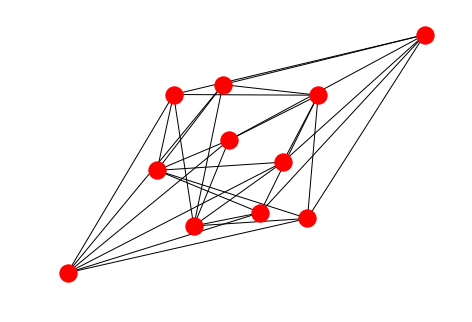

In [0]:
# import networkx as nx
# #import nx.drawing.nx_pylab as pylab
# import numpy as np
# import matplotlib.pyplot as plt

# G = nx.Graph()
# #G.add_nodes_from([1,2,3,4,5,6,7,'A','B','C','D','E','Z'])
# G.add_edges_from(
#     [
#      ('1', 'A'), ('1', 'B'), ('1', 'C'), ('1', 'D'), ('1', 'E'),
#      ('2', 'A'), ('2', 'B'), ('2', 'C'), ('2', 'D'), ('2', 'E'),
#      ('3', 'A'), ('3', 'B'), ('3', 'C'), ('3', 'D'), ('3', 'E'),
#      ('4', 'A'), ('4', 'B'), ('4', 'C'), ('4', 'D'), ('4', 'E'),
#      ('5', 'A'), ('5', 'B'), ('5', 'C'), ('5', 'D'), ('5', 'E'),
#      ('6', 'A'), ('6', 'B'), ('6', 'C'), ('6', 'D'), ('6', 'E'),
#      ])

# nx.draw(G)
# plt.show()
# plt.savefig('network.png')

AttributeError: 'module' object has no attribute 'graphviz_layout'

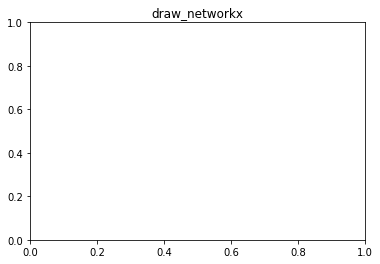

In [47]:
# import networkx as nx
# import matplotlib.pyplot as plt
# G = nx.DiGraph()

# G.add_node("ROOT")

# for i in xrange(5):
#     G.add_node("Child_%i" % i)
#     G.add_node("Grandchild_%i" % i)
#     G.add_node("Greatgrandchild_%i" % i)

#     G.add_edge("ROOT", "Child_%i" % i)
#     G.add_edge("Child_%i" % i, "Grandchild_%i" % i)
#     G.add_edge("Grandchild_%i" % i, "Greatgrandchild_%i" % i)

# # write dot file to use with graphviz
# # run "dot -Tpng test.dot >test.png"
# #nx.write_dot(G,'test.dot')

# # same layout using matplotlib with no labels
# plt.title('draw_networkx')
# pos=nx.graphviz_layout(G, prog='dot')
# nx.draw(G, pos, with_labels=False, arrows=False)
# plt.savefig('nx_test.png')

NetworkXError: Node 'A' has no position.

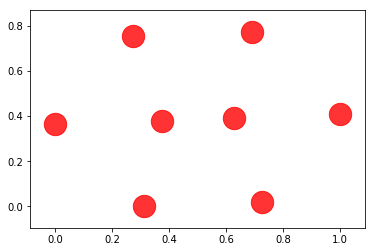